# APF filter

Cheryl Kouadio  
Safa Bouzayene  
Mariyam Ouyassin  
2025-02-26

# 1. Méthodes : étude de simulation sur la performance du filtre APF

## 1.1 Modèle utilisé

Le filtre particulaire APF (Auxiliary Particle Filter) est un filtre
particulaire qui utilise des particules auxiliaires pour estimer la
densité de probabilité de l’état caché. Il est utilisé pour estimer
l’état caché d’un système dynamique non linéaire. Dans cet article, nous
allons étudier la performance du filtre APF en utilisant un exemple
simple.

Comme tout filtre particulaire, il est necessaire de spécifier la
distribution a priori de l’état, i.e. $p(x_0)$, la distribution de
transition, i.e. $p(v_t|v_{t-1})$ et la vraisemblance,
i.e. $p(y_t|v_t)$.

Dans le modèle de Heston spécifié en (1), on considère que : $$
p(v_t|v_{t-1})=2c\chi^2(2cx_k; 2q + 2; 2ce^{-\kappa \Delta} x_{k−1}),
$$

$$p(v_1) = \Gamma(v_1; a,b)$$ où $a = \frac{2 \kappa \theta}{\sigma^2}$
et $b = \frac{2 \kappa}{\sigma^2}$,

et $p(y_t)|v_t) = N(0,h)$.

$$
\begin{cases}
dS_t = S_t \left( rds + \sqrt{v_t} dW_t^1 \right) \\
dv_t = \kappa (\theta - v_t) ds + \sigma \sqrt{v_t} dW_t^2 \\
dW_t^1 dW_t^2 = \rho ds
\end{cases}
\quad (1)
$$

Pour tester la pertinence de l’APF, nous allons utiliser les paramètres
suivants
$\Phi = (\theta = 0.03, \kappa = 4, \sigma = 0.4, \kappa = -0.87, \rho = 0.5)$.
Pour passer en temps discret et assurer la positivité de la volatilité,
nous utilisosn le schema d’euler (à $|v_t|$) suivant :

$$
\begin{cases}
y_t = C(t, \theta, v_t, S_t, K, \tau) + \varepsilon_t, \\[10pt]
v_t = \left| v_{t-1} + \kappa \Delta (\theta - v_{t-1}) + \sigma \sqrt{v_{t-1}\Delta} (\rho w_t^1 + \sqrt{1-\rho^2}w_t^2) \right|, \\[10pt]
S_t = S_{t-1} \left(1 + \mu \Delta + \sqrt{\Delta v_t} w_t^1 \right), \\[10pt]
\end{cases}
$$

où $\varepsilon_t \sim N(0,h=0.01)$, et $w_t^1, w_t^2$ sont des
variables aléatoires gaussiennes et indépendantes.

Nous avons utilisé un schéma d’euler modifié pour garantir la positivité
de la volatilité. En effet, la volatilité doit être positive dans le
modèle de Heston, et le schéma d’euler standard peut produire des
valeurs négatives. En prenant la valeur absolue de la volatilité à
chaque étape, nous nous assurons que les valeurs restent positives. Il
aurait été également possible d’utiliser le schéma d’euler à $ln(v_t)$
(via le lemme de ito) pour garantir la positivité de la volatilité.

In [ ]:
rm(list=ls())

################ Simulation de la trajectoire de St et vt ################ 
Heston_sim <- function(N, kappa, theta, sigma, rho, v0, mu, tau, S0){
  # N: Number of time steps
  dt <- tau / N  # Time step

  # Store stock prices and volatilities
  S <- numeric(N+1)
  v <- numeric(N+1)
  
  S[1] <- S0
  v[1] <- v0
  
  for (t in 1:N){
    # Generate correlated Brownian motions
    W1 <- rnorm(1)
    W2 <- rho * W1 + sqrt(1 - rho^2) * rnorm(1)
    
    # Euler discretization of variance process (ensure non-negativity)
    v[t+1] <- abs(v[t] + kappa * (theta - v[t]) * dt + sigma * sqrt(v[t] * dt) * W2)
    
    # Euler discretization of the stock price process 
    S[t+1] <- S[t] * (1+ mu*dt + sqrt(v[t+1] * dt) * W1)
  }
  
  return(list(v_t = v, S_t=S))
}

Avec les étapes 1 et 2, nous obtenons les trajectoires de volatilité
instantanée et de prix d’action suivantes :

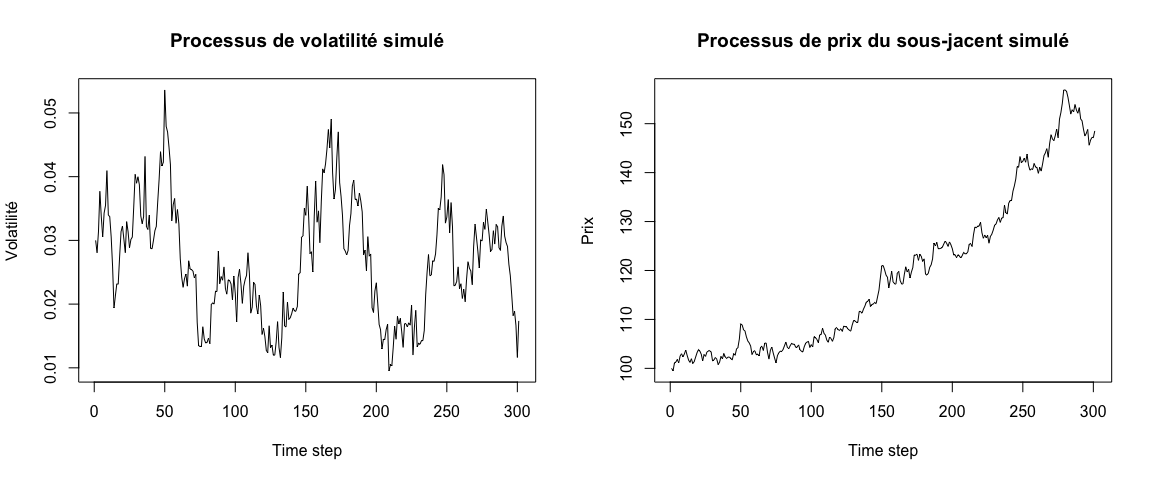

In [ ]:
set.seed(123)
N <- 300
theta <- 0.03
kappa <- 4
sigma <- 0.4
rho <- 0.5
v0 <- 0.03
mu <- 0.1
tau<-1
S0 <- 100

res <- Heston_sim(N=N, kappa=kappa, theta=theta, sigma=sigma, rho=rho, v0=v0, mu=mu, tau=tau, S0=S0)

par(mfrow=c(1,2))
plot(res$v_t, type="l", main="Processus de volatilité simulé", xlab = "Time step", ylab = "Volatilité") 
plot(res$S_t, type="l", main="Processus de prix du sous-jacent simulé", xlab = "Time step", ylab = "Prix") 

### 1.1.1 Procédure de simulation

La procédure de simulation est la suivante :

1.  Tout d’abord, une trajectoire de 300 pas de temps de la variance
    instantanée sera simulée pour un pas de 1 jour, en commençant par
    $v_0$ = 0,03.

2.  Conditionnellement à cette trajectoire, une trajectoire
    correspondante du prix de l’action sera alors générée.

3.  Nous calculons, à l’aide du modèle de Heston, les prix d’options
    bruités pour trois types d’options différents : une option à la
    monnaie (ATM), une option dans la monnaie (ITM) et une option mixte
    (50 % ITM / 50 % OTM).

Nous avons choisi trois types d’options afin d’observer comment le
filtre APF se comporte dans différentes conditions de marché :

-   Option à la monnaie (ATM) :
    -   Prix d’exercice : `K = 1 × S_t`
    -   Temps avant l’échéance : `τ = 0.5` Les options ATM sont souvent
        utilisées pour l’estimation de la volatilité implicite, car
        elles sont les plus liquides et présentent un delta proche de
        0.5, ce qui les rend sensibles aux variations du sous-jacent.
-   Option dans la monnaie (ITM) :
    -   Prix d’exercice : `K = 0.95 × S_t`
    -   Temps avant l’échéance : `τ = 0.5` Les options ITM ont une
        valeur intrinsèque élevée et une volatilité implicite plus
        stable. Elles sont moins sensibles aux fluctuations immédiates
        du marché mais permettent d’évaluer l’impact du filtre APF dans
        des conditions de faible variance du prix d’option.
-   Option mixte (50 % ITM / 50 % OTM) :
    -   Prix d’exercice : `K = 117`
    -   Temps avant l’échéance : `τ = 0.5` Cette approche permet de
        tester le filtre APF dans un scénario réaliste de portefeuille
        d’options où des positions ITM et OTM sont combinées. L’objectif
        est d’analyser si le filtre reste stable lorsque l’on mélange
        des options avec des sensibilités différentes aux mouvements du
        sous-jacent et aux variations de volatilité.

**Pourquoi tester différentes configurations d’options ?**

L’objectif de cette analyse est de vérifier comment le filtre APF se
comporte en présence de conditions de marché variées :

-   Options ATM : impact fort de la volatilité, mais moins sujettes au
    risque de gamma.
-   Options ITM : faible sensibilité à la volatilité implicite, mais
    risque de couverture plus limité.
-   Options mixtes : évaluation de la robustesse du filtre lorsque
    plusieurs types d’options coexistent dans un même portefeuille.

Ces tests permettent de comparer la précision du filtre en fonction de
la position de l’option par rapport au prix du sous-jacent.

In [ ]:
################ Simulation du prix des options ATM ################ 
source("data/Heston_Call_Function.R")
set.seed(123)

v_t <- res$v_t 
S_t <- res$S_t
h <- 0.01

# Prix d'option K=1*S, tau = 0.5 => A la monnaie
r <- 5/100
tau <- 0.5
K <- 1
ATM <- numeric(N+1)

for(i in c(0:N+1)){
ATM[i] <- HestonCallClosedForm(lambda = kappa, vbar = theta, eta = sigma, rho = rho, v0 = v_t[i], r = r, tau = tau, S0 = S_t[i], K = K * S_t[i])
}

res$ATM <- ATM + rnorm(1,mean=0,sd=sqrt(h))

################ Simulation du prix des options ITM ################ 
# Prix d'option K=0.95*S, tau = 0.5 => Hors de la monnaie
r <- 5/100
tau <- 0.5
K <- 0.95

ITM <- numeric(N+1)

for(i in c(0:N+1)){
ITM[i] <- HestonCallClosedForm(lambda = kappa, vbar = theta, eta = sigma, rho = rho, v0 = v_t[i], r = r, tau = tau, S0 = S_t[i], K = K * S_t[i])
}
res$ITM <- ITM + rnorm(1,mean=0,sd=sqrt(h))

################ Simulation du prix des options mixte ################ 
summary(S_t)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  99.49  104.36  117.23  119.24  128.88  156.89 

#### 1.1.1.1 Prix d’options simulés

En simulant le prix de ces options, nous constatons sans surprise que
les options mixte ont un prix plus élevé plus on se rapproche de la
maturité. Cependant, les options ITM et ATM ont des prix plus stables,
avec une légère augmentation pour les options ITM.

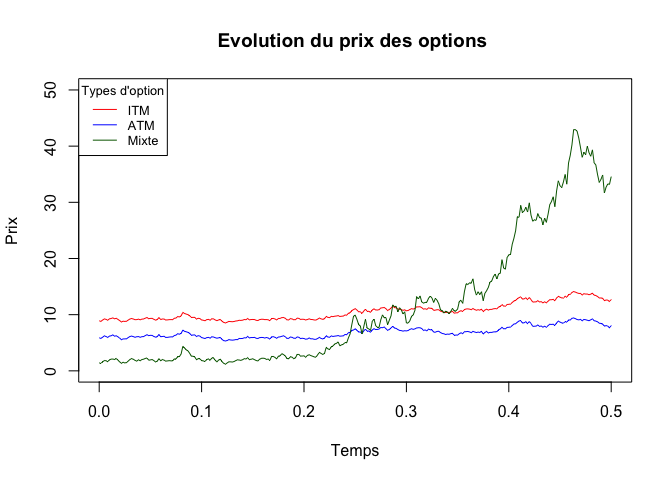

In [ ]:
N <- length(res$ITM)  
dt <- tau / N
time_axis <- seq(0, tau, length.out = N)  # Axe des temps, de 0 à tau

plot(time_axis,res$ITM, type="l", main = "Evolution du prix des options ", ylim = c(0,50), col = "red", ylab = "Prix", xlab = "Temps")
lines(time_axis,res$ATM, type = "l",col="blue")
lines(time_axis,res$MIXTE, type='l', col= "darkgreen")
# legend
legend("topleft", legend=c("ITM", "ATM", "Mixte"), col=c("red", "blue",'darkgreen'), lty=1:1, cex=0.8, title="Types d'option")

#### 1.1.1.2 Filtres utilisés

L’objectif est de comparer les résultats de l’APF sur du filtre
particulaire bootstrap en termes d’erreurs d’ajustement, mesurées par
les erreurs quadratiques moyennes (RMSE) de l’ajustement de la variance
et de l’ajustement des prix des options, dans différents cas de données.

**Filtre bootstrap :**

Le filtre boostrap fonctionne de la manière suivante :

<figure>
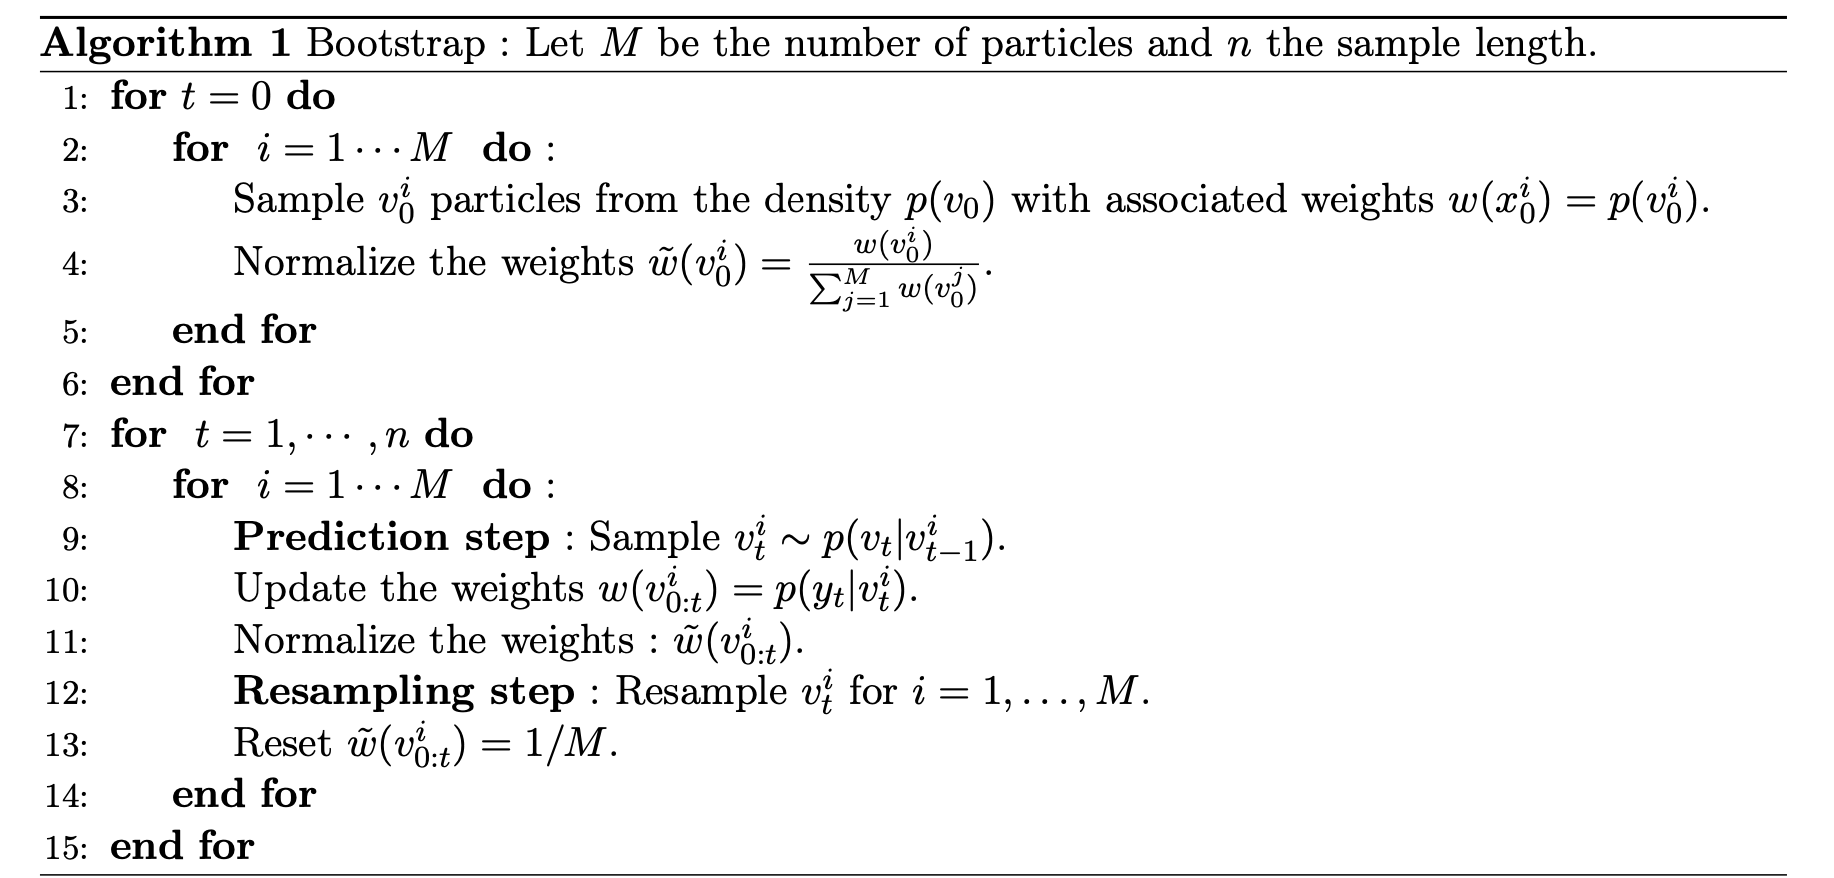
<figcaption aria-hidden="true">Bootstrap filter</figcaption>
</figure>

Dans le cadre du modèle de heston, nous avons implémenté le filtre
bootstrap de la manière suivante :

In [ ]:
BootstrapParticleFilter <- function(y, S, v, K, tau = 0.5, M = 200, theta = 0.03, kappa = 4, sigma = 0.4, rho = 0.5, r = 0.05, dt = 1, h = 0.01) {
  
  # Paramètres supplémentaires
  sigma_epsilon <- sqrt(h)

  # Paramètres de la loi stationnaire de v
  alpha1 <- (2 * kappa * theta) / (sigma^2)
  alpha2 <- (sigma^2) / (2 * kappa)

  # Initialisation
  n <- length(y)
  v_hat <- numeric(n)
  v_particle <- matrix(nrow = n, ncol = M)
  w <- matrix(nrow = n, ncol = M)
  w_normalized <- matrix(nrow = n, ncol = M)

  # Filtre particulaire bootstrap
  for (t in 1:n) {
    if (t == 1) {
      # Initialisation des particules à t = 0
      v_particle[t, ] <- rgamma(M, shape = alpha1, rate = 1/alpha2)
      
      # Poids initiaux basés sur la densité de la loi stationnaire
      w[t, ] <- dgamma(v_particle[t, ], shape = alpha1, rate = 1/alpha2)
      
      # Normalisation des poids
      w_normalized[t, ] <- w[t, ] / sum(w[t, ])
      
      # Estimation initiale
      v_hat[t] <- sum(w_normalized[t, ] * v_particle[t, ])
    } else {
      # Étape de prédiction (propagation des particules)
      v_particle[t, ] <- abs(rnorm(M, 
                                    mean = v_particle[t-1, ] + kappa * (theta - v_particle[t-1, ]) * dt, 
                                    sd = sigma * sqrt(v_particle[t-1, ] * dt)))
      
      #  Calcul du prix du Call pour chaque particule
      C <- numeric(M)
      
      # Si K est un unique scalaire (strike constant), on le conserve
      # Si K est un vecteur, on prend K[t] comme strike au temps t
      if (length(K) == 1) {
          Kt <- K  # Strike constant
      } else {
          Kt <- K[t]  # Strike spécifique au temps t
      }
      
      # Calcul pour chaque particule avec le bon strike
      for (i in 1:M) {
          C[i] <- HestonCallClosedForm(lambda = kappa, vbar = theta, eta = sigma, rho = rho, 
                                       v0 = v_particle[t, i], r = r, tau = tau, S0 = S[t], K = Kt)
      }

      
      # Mise à jour des poids (vraisemblance observation-conditionnelle)
      w[t, ] <- dnorm(y[t], mean = C, sd = sqrt(sigma_epsilon))
      
      # Normalisation des poids
      w_normalized[t, ] <- w[t, ] / sum(w[t, ])
      
      # Rééchantillonnage
      index <- sample(1:M, size = M, prob = w_normalized[t, ], replace = TRUE)
      v_particle[t, ] <- v_particle[t, index]
      
      # Poids uniformes après resampling
      w_normalized[t, ] <- rep(1 / M, M)

      # Estimation de la volatilité instantanée
      v_hat[t] <- sum(w_normalized[t, ] * v_particle[t, ])
    }
  }

  return(v_hat)
}

**Filtre APF :**

Le filtre particulaire auxilaire fonctionne de la manière suivante :

<figure>
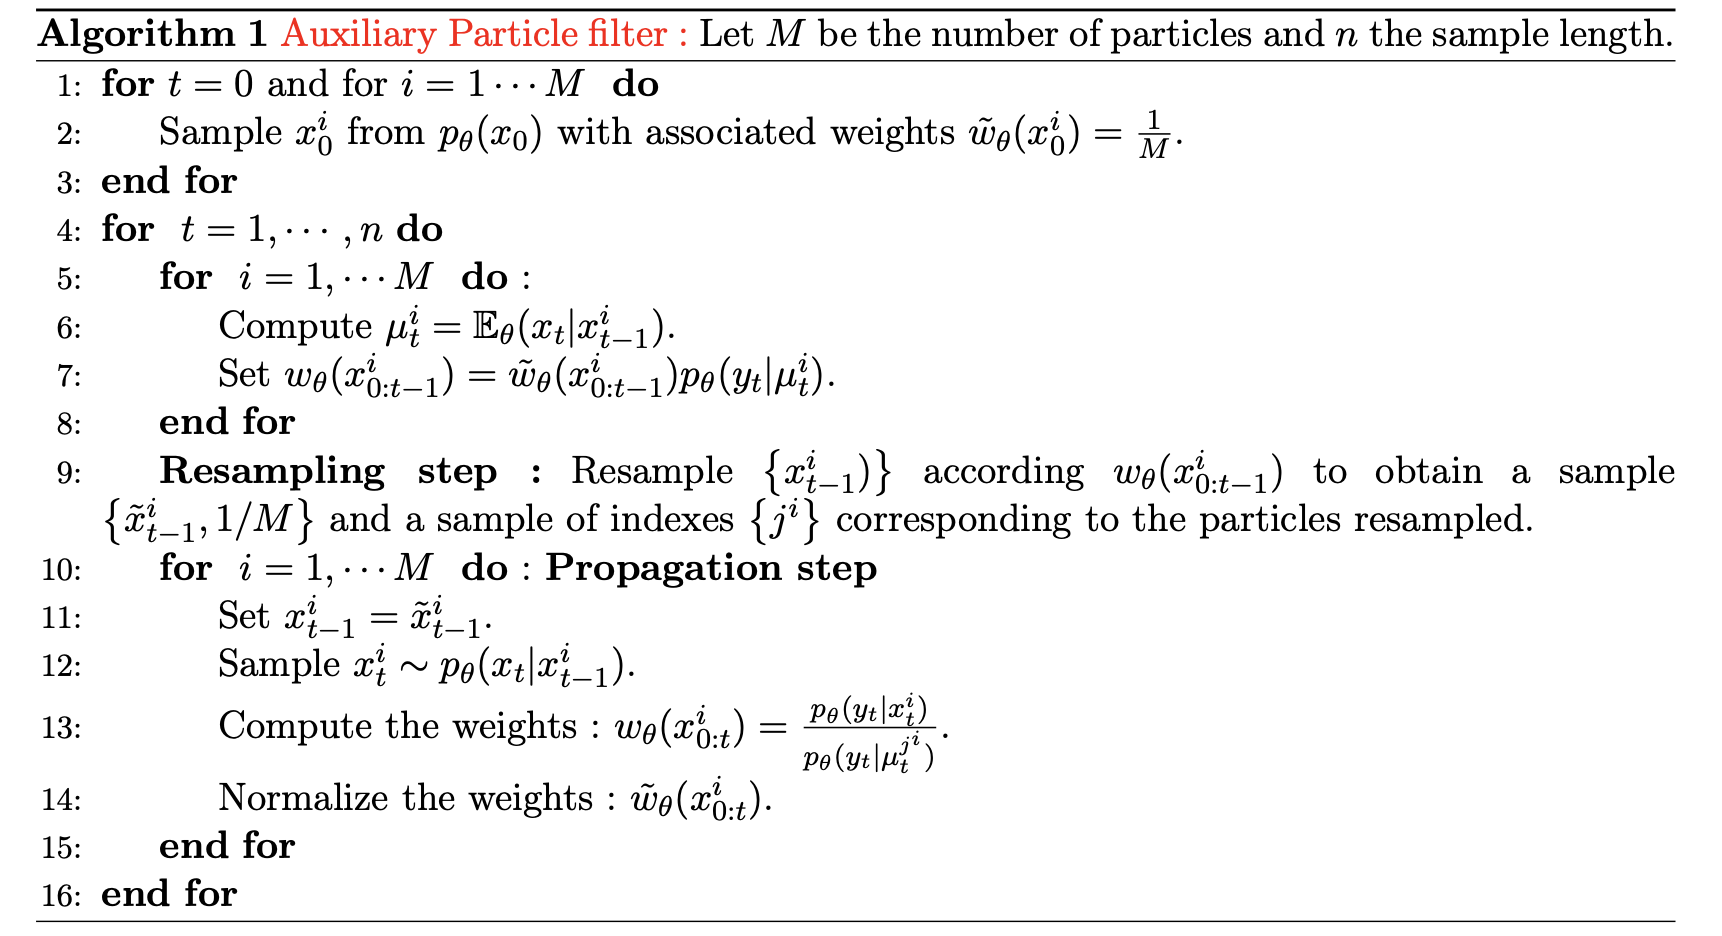
<figcaption aria-hidden="true">APF</figcaption>
</figure>

Dans le cadre du modèle de heston, nous avons implémenté le filtre APF
de la manière suivante :

In [ ]:
APF_Heston <- function(y, S, v,K, M = 200, theta = 0.03, kappa = 4, sigma = 0.4, 
                       lambda = -0.87, rho = 0.5, r = 0.05, tau = 0.5, dt = 1, h = 0.01) {
  
  # Paramètres de la loi stationnaire de v
  sigma_epsilon <- sqrt(h)
  alpha1 <- (2 * kappa * theta) / (sigma^2)
  alpha2 <- (sigma^2) / (2 * kappa)

  # Initialisation des paramètres
  n <- length(y)
  
  # Initialisation des vecteurs/matrices
  v_hat <- numeric(n)                   
  v_particle <- matrix(nrow = n, ncol = M)
  mu <- matrix(nrow = n, ncol = M)        
  py_mu <- matrix(nrow = n, ncol = M) 
  w <- matrix(nrow = n, ncol = M)
  w_normalized <- matrix(nrow = n, ncol = M)

  # Filtre particulaire APF
  for (t in 1:n) {
    if (t == 1) {
      
      v_particle[t, ] <- rgamma(M, shape = alpha1, rate = 1/alpha2)
      w[t, ] <- rep(1 / M, M)
      w_normalized[t, ] <- w[t, ] / sum(w[t, ])
      v_hat[t] <- sum(w_normalized[t, ] * v_particle[t, ])
      
    } else {
      
      # Si K est un unique scalaire (strike constant), on le conserve
      # Si K est un vecteur, on prend K[t] comme strike au temps t
      if (length(K) == 1) {
          Kt <- K  # Strike constant
      } else {
          Kt <- K[t]  # Strike spécifique au temps t
      }
      
      # 1 - Pré-sélection
      mu[t, ] <- abs(v_particle[t-1, ] + kappa * (theta - v_particle[t-1, ]) * dt)
      
      mean_pymu <- numeric(M)
      for (i in 1:M) {
        mean_pymu[i] <- HestonCallClosedForm(lambda = kappa, vbar = theta, eta = sigma, rho = rho, 
                                             v0 = mu[t, i], r = r, tau = tau, S0 = S[t], K = Kt)
      }
      py_mu[t, ] <- dnorm(y[t], mean = mean_pymu, sd = sigma_epsilon)

      # Poids pour la pré-sélection
      w[t-1, ] <- py_mu[t, ] * w_normalized[t-1, ]
      
      # 2 - Resampling (échantillonnage)
      index <- sample(1:M, size = M, replace = TRUE, prob = w[t-1, ])

      # Mise à jour des particules
      v_particle[t-1, ] <- v_particle[t-1, index]
      
      # 3 - Propagation (évolution des particules)
      v_particle[t, ] <- abs(rnorm(M, 
                                   mean = v_particle[t-1, ] + kappa * (theta - v_particle[t-1, ]) * dt, 
                                   sd = sigma * sqrt(v_particle[t-1, ] * dt)))

      # Mise à jour des poids
      C <- numeric(M)
      for (i in 1:M) {
        C[i] <- HestonCallClosedForm(lambda = kappa, vbar = theta, eta = sigma, rho = rho, 
                                     v0 = v_particle[t, i], r = r, tau = tau, S0 = S[t], K = Kt)
      }
      likelihood <- dnorm(y[t], mean = C, sd = sigma_epsilon)
      w[t, ] <- likelihood / (py_mu[t, index] + 1e-12)  # Protection pour éviter la division par zéro
      
      w_normalized[t, ] <- w[t, ] / sum(w[t, ])
      v_hat[t] <- sum(w_normalized[t, ] * v_particle[t, ])
    }
  }

  # Retourner les résultats
  return(v_hat)
}

**Différence entre le filtre bootstrap et le filtre APF :**

Le filtre bootstrap et le filtre APF sont deux méthodes de filtrage
particulaire qui permettent d’estimer l’état caché d’un système
dynamique non linéaire. La principale différence entre ces deux méthodes
réside dans la manière dont elles mettent à jour les poids des
particules, et ainsi comme la distribution d’importance q est
construite. Par définition, les poids sont définis par : $$
w(x_t) = w(x_{t-1}) \frac{p(y_t|x_t)p(x_t|x_{t-1})}{q(x_t|x_{t-1},y_t)},
$$ où $p(y_t|x_t)$ est la vraisemblance, $p(x_t|x_{t-1})$ est la
distribution de transition, et $q(x_t|x_{t-1},y_t)$ est la distribution
d’importance.

Dans le cadre du filtre bootstrap, la distribution d’importance est
définie comme suit : $$
q(x_t|x_{t-1},y_t) = p(x_t|x_{t-1}).
$$ De ce fait, $w(x_t) = w(x_{t-1}) p(y_t|x_t)$.Cela signifie que les
poids sont mis à jour en fonction de la distribution de transition et de
la vraisemblance.

Dans le cadre du filtre APF, la distribution d’importance se rapproche
de la distribution optimale, vu dans la littérature comme étant
$q(x_t|x_{t-1},y_t) = p(x_t|x_{t-1},y_t)$. De ce fait, les poids sont
mis à jour en fonction de la vraisemblance conditionnelle, ce qui permet
d’améliorer la précision de l’estimation de l’état caché, et donc de
l’estimation de la volatilité dans notre cas.

# 2. Résultats

## 2.1 Option à la monnaie (ATM)

### 2.1.1 Filtre bootstrap

In [ ]:
##################### Définition des paramètres #####################
# Définition des paramètres phi
theta <- 0.03
kappa <- 4
sigma <- 0.4
lambda <- -0.87 # Prime de risque
rho <- 0.5

# Paramètres de Heston 
h <- 0.01
r <- 0.05

# Prix de call (y), du sous-jacent (S), et volatilité instantanée (v)
y <- res$ATM
S <- res$S_t
v<- res$v_t

# Initialisation des paramètres
n <- length(y)  # Nombre d'observations
M <- 200      # Nombre de particules
dt <- 1

In [ ]:
set.seed(123)

# Paramètres de l'option 
K <- 1 * S
tau<- 0.5

# Exemple d'appel avec tes données "res"
et_boot_atm <- system.time({
boot_atm <- BootstrapParticleFilter(y=y, S=S, v=v, K=K, tau = tau, M = M, theta = theta, kappa = kappa, sigma = sigma,  rho = rho, r = r, dt = dt, h = h)
})

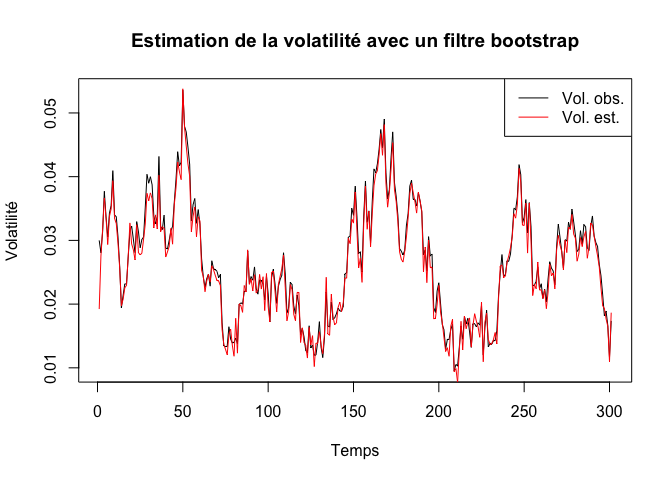

In [ ]:
plot(v, type = "l", col = "black",  main = "Estimation de la volatilité avec un filtre bootstrap",xlab = "Temps", ylab = "Volatilité")
lines(boot_atm, type = "l", col = "red")
legend("topright", legend = c("Vol. obs.", "Vol. est."), col = c("black", "red"), lty = 1)

In [ ]:
print(et_boot_atm)

   user  system elapsed 
 11.727   0.487  12.216 

RMSE : 0.001402773

### 2.1.2 Filtre APF

In [ ]:
set.seed(123)
et_apf_atm <- system.time({
apf_atm <- APF_Heston(y=y, S=S, v=v, K=K, tau = tau, M = M, theta = theta, kappa = kappa, sigma = sigma,  rho = rho, r = r, dt = dt, h = h)
})

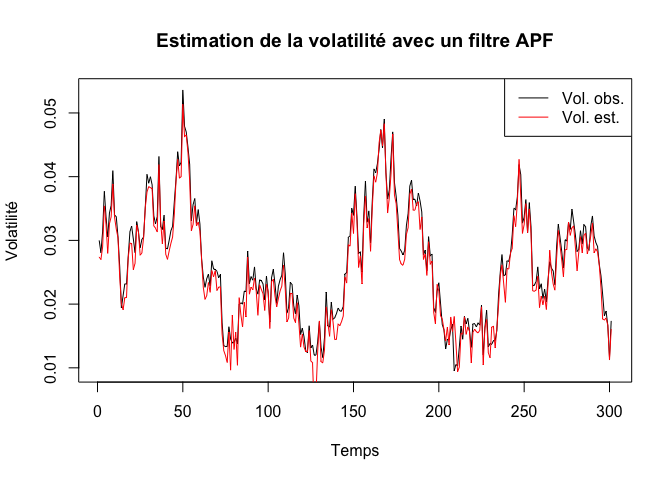

In [ ]:
plot(v, type = "l", col = "black",  main = "Estimation de la volatilité avec un filtre APF",xlab = "Temps", ylab = "Volatilité")
lines(apf_atm, type = "l", col = "red")
legend("topright", legend = c("Vol. obs.", "Vol. est."), col = c("black", "red"), lty = 1)

In [ ]:
print(et_apf_atm)

   user  system elapsed 
 23.245   0.945  24.206 

RMSE : 0.001889304

## 2.2 Option à la monnaie (ITM)

### 2.2.1 Filtre bootstrap

In [ ]:
set.seed(123)
y <- res$ITM
K <- 0.95 * S

et_boot_itm <- system.time({
boot_itm <- BootstrapParticleFilter(y=y, S=S, v=v, K=K, tau = tau, M = M, theta = theta, kappa = kappa, sigma = sigma,  rho = rho, r = r, dt = dt, h = h)
})

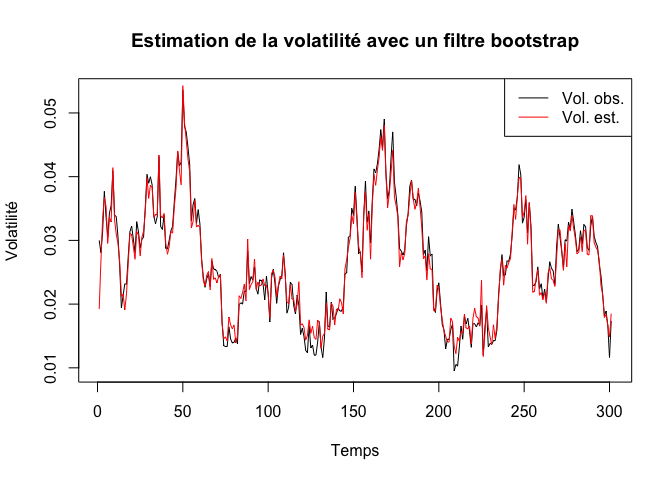

In [ ]:
plot(v, type = "l", col = "black",  main = "Estimation de la volatilité avec un filtre bootstrap",xlab = "Temps", ylab = "Volatilité")
lines(boot_itm, type = "l", col = "red")
legend("topright", legend = c("Vol. obs.", "Vol. est."), col = c("black", "red"), lty = 1)

In [ ]:
print(et_boot_itm)

   user  system elapsed 
 11.276   0.433  11.757 

RMSE : 0.00152023

### 2.2.2 APF

In [ ]:
et_apf_itm <- system.time({
apf_itm <- APF_Heston(y=y, S=S, v=v, K=K, tau = tau, M = M, theta = theta, kappa = kappa, sigma = sigma,  rho = rho, r = r, dt = dt, h = h)
})

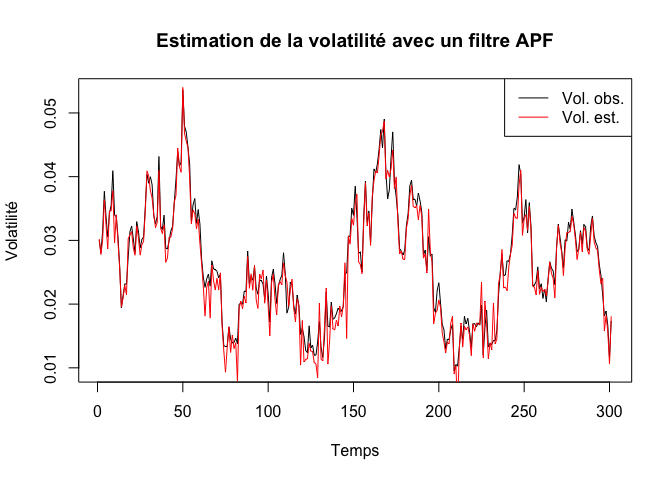

In [ ]:
plot(v, type = "l", col = "black",  main = "Estimation de la volatilité avec un filtre APF",xlab = "Temps", ylab = "Volatilité")
lines(apf_itm, type = "l", col = "red")
legend("topright", legend = c("Vol. obs.", "Vol. est."), col = c("black", "red"), lty = 1)

In [ ]:
print(et_apf_itm)

   user  system elapsed 
 22.268   0.832  23.100 

RMSE : 0.001850903

## 2.3 Options mixtes

### 2.3.1 Filtre bootstrap

In [ ]:
set.seed(123)
y <- res$MIXTE
K <- 117

et_boot_mixte <- system.time({
boot_mixte <- BootstrapParticleFilter(y=y, S=S, v=v, K=K, tau = tau, M = M, theta = theta, kappa = kappa, sigma = sigma,  rho = rho, r = r, dt = dt, h = h)
})

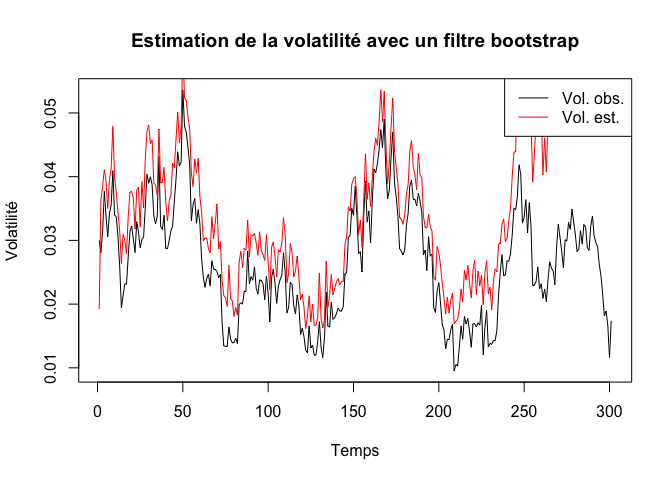

In [ ]:
plot(v, type = "l", col = "black",  main = "Estimation de la volatilité avec un filtre bootstrap",xlab = "Temps", ylab = "Volatilité")
lines(boot_mixte, type = "l", col = "red")
legend("topright", legend = c("Vol. obs.", "Vol. est."), col = c("black", "red"), lty = 1)

In [ ]:
print(et_boot_mixte)

   user  system elapsed 
 11.816   0.422  12.240 

RMSE : 0.01595637

### 2.3.2 APF

In [ ]:
et_apf_mixte <- system.time({
apf_mixte <- APF_Heston(y=y, S=S, v=v, K=K, tau = tau, M = M, theta = theta, kappa = kappa, sigma = sigma,  rho = rho, r = r, dt = dt, h = h)
})

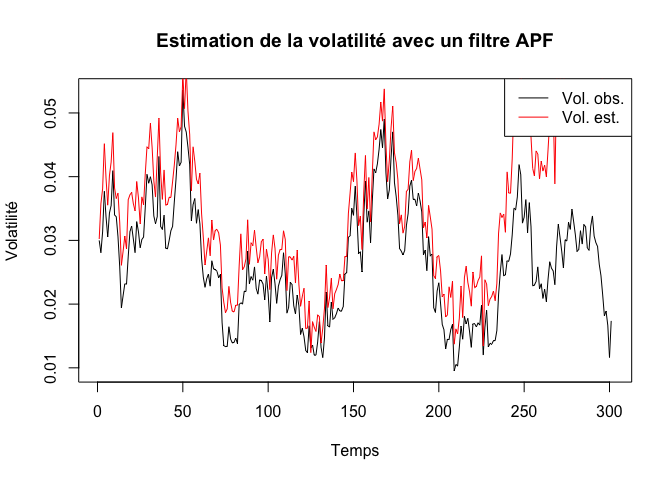

In [ ]:
plot(v, type = "l", col = "black",  main = "Estimation de la volatilité avec un filtre APF",xlab = "Temps", ylab = "Volatilité")
lines(apf_mixte, type = "l", col = "red")
legend("topright", legend = c("Vol. obs.", "Vol. est."), col = c("black", "red"), lty = 1)

In [ ]:
print(et_apf_mixte)

   user  system elapsed 
 23.381   0.862  24.273 

RMSE : 0.01475175

## 2.4 Comparaison des performances

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

# A tibble: 4 × 3
  Type_Option     APF    BOOT
  <chr>         <dbl>   <dbl>
1 ATM         0.00189 0.00140
2 ITM         0.00185 0.00152
3 MIXTE       0.0148  0.0160 
4 Moyenne     0.00616 0.00629

In [ ]:
# Comparaison des temps d'exécution
comp_temps <- data.frame(
    Méthode = c("APF", "APF", "APF", "BOOT", "BOOT", "BOOT"),
    Type_Option = c("ATM", "ITM", "MIXTE", "ATM", "ITM", "MIXTE"),
    Temps = c(et_apf_atm[3], et_apf_itm[3], et_apf_mixte[3], et_boot_atm[3], et_boot_itm[3], et_boot_mixte[3])
)

# Conversion : Méthode comme colonne
comp_temps_wide <- pivot_wider(
    comp_temps,
    names_from = Méthode,   # Ce qui devient les colonnes
    values_from = Temps      # Ce qui remplit les cases
)

comp_temps_wide <- bind_rows(
    comp_temps_wide,
    data.frame(
        Type_Option = "Moyenne",
        APF = mean(c(et_apf_atm[3], et_apf_itm[3], et_apf_mixte[3]), na.rm = TRUE),
        BOOT = mean(c(et_boot_atm[3], et_boot_itm[3], et_boot_mixte[3]), na.rm = TRUE)
    )
)
# Affichage du résultat
comp_temps_wide

# A tibble: 4 × 3
  Type_Option   APF  BOOT
  <chr>       <dbl> <dbl>
1 ATM          24.2  12.2
2 ITM          23.1  11.8
3 MIXTE        24.3  12.2
4 Moyenne      23.9  12.1

En comparant les performances de l’APF à celles du filtre bootstrap,
nous constatons que les deux filtres ont des performances assez
similaires en termes d’erreurs d’ajustement (RMSE) pour les options ATM
et ITM. Cependant, l’APF semble être plus efficace pour les options
mixtes, avec des erreurs d’ajustement plus faibles que le filtre
bootstrap. Cependant, en termes de temps d’exécution, le filtre
bootstrap est plus rapide que l’APF pour les trois types d’options. En
moyenne, l’APF est plus lent que le filtre bootstrap, mais offre une
meilleure précision tout option confondue.

Pou connaitre la robustesse de ces estimations, nous avons fait du
bootstrap pour estimer la distribution des RMSE, et ainsi obtenir des
intervalles de confiance pour ces estimations, de même que des
p-valeurs. Le code ayant servi à la simulation est disponible ici.

Warning in rep(c("Bootstrap Filter", "APF-Heston"), each =
c(length(rmse_bootstrap_atm), : first element used of 'each' argument

Warning in rep(c("ATM", "ATM", "ITM", "ITM", "MIXTE", "MIXTE"), each =
c(length(rmse_bootstrap_atm), : first element used of 'each' argument

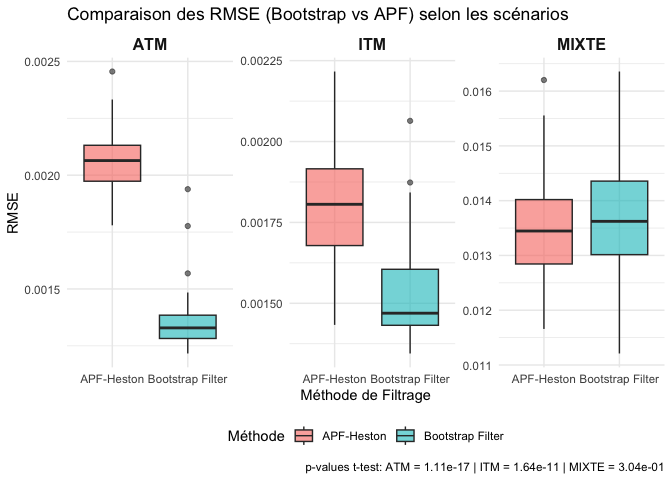

In [ ]:
library(ggplot2)
library(dplyr)
library(ggpubr)

# Charger les résultats du bootstrap
res_ATM <- readRDS("results_sim/res_ATM_min.rds")
res_ITM <- readRDS("results_sim/res_ITM_min.rds")
res_MIXTE <- readRDS("results_sim/res_MIXTE_min.rds")

# Extraire les RMSE
rmse_bootstrap_atm <- res_ATM$t[, 1]
rmse_apf_atm_b <- res_ATM$t[, 2]

rmse_bootstrap_itm <- res_ITM$t[, 1]
rmse_apf_itm_b <- res_ITM$t[, 2]

rmse_bootstrap_mixte <- res_MIXTE$t[, 1]
rmse_apf_mixte_b <- res_MIXTE$t[, 2]

# Créer un dataframe avec les valeurs RMSE pour les trois scénarios
df_rmse_boxplot <- data.frame(
  Méthode = rep(c("Bootstrap Filter", "APF-Heston"), each = c(length(rmse_bootstrap_atm), length(rmse_apf_atm_b), length(rmse_bootstrap_itm), length(rmse_apf_itm_b),length(rmse_bootstrap_mixte), length(rmse_apf_mixte_b))),
  RMSE = c(rmse_bootstrap_atm, rmse_apf_atm_b,
           rmse_bootstrap_itm, rmse_apf_itm_b,
           rmse_bootstrap_mixte, rmse_apf_mixte_b),
  Scénario = rep(c("ATM", "ATM", "ITM", "ITM", "MIXTE", "MIXTE"), each = c(length(rmse_bootstrap_atm), length(rmse_apf_atm_b),
length(rmse_bootstrap_itm), length(rmse_apf_itm_b),
length(rmse_bootstrap_mixte), length(rmse_apf_mixte_b)))
)

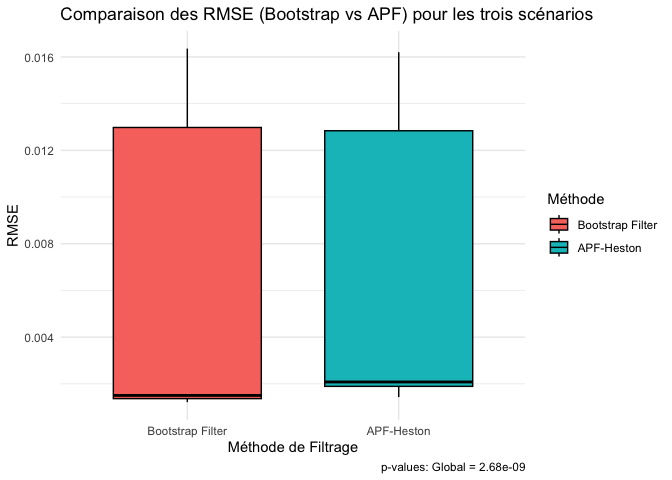

In [ ]:
# Concaténer toutes les RMSE
total_rmse_bootstrap <- c(rmse_bootstrap_atm, rmse_bootstrap_itm, rmse_bootstrap_mixte)
total_rmse_apf <- c(rmse_apf_atm_b, rmse_apf_itm_b, rmse_apf_mixte_b)

# Kruskal wallis test
global_pval <- kruskal.test(list(total_rmse_bootstrap, total_rmse_apf))$p.value

# global_pval <- t.test(total_rmse_bootstrap, total_rmse_apf)$p.value

# Boxplot global
ggboxplot(df_rmse_boxplot, x = "Méthode", y = "RMSE", fill = "Méthode",
          ylab = "RMSE", xlab = "Méthode de Filtrage",
          title = "Comparaison des RMSE (Bootstrap vs APF) pour les trois scénarios") +
  labs(caption = paste("p-values: Global =", formatC(global_pval, format = "e", digits = 2))) +
  theme_minimal()

**Approche pvalue** :

In [ ]:
rmse_diff_atm <- rmse_bootstrap_atm - rmse_apf_atm_b
rmse_diff_atm_obs <- rmse_boot_atm - rmse_apf_atm

mean(rmse_diff_atm_obs > rmse_diff_atm)

[1] 0.84

[1] 0.38

[1] 1

**Conclusion :** L’APF est une méthode plus précise que le filtre
bootstrap pour estimer la volatilité instantanée dans le cadre d’un
modèle de Heston où le prix est bruité $h=0.01$, mais elle est également
plus lente en termes de temps d’exécution. Le choix entre ces deux
méthodes dépendra donc des besoins spécifiques de l’analyse, en fonction
de la précision et de la vitesse d’exécution requises.

Pour tester la robustesse de ces estimations, il aurait fallu faire du
bootstrap afin d’estimer la distribution des RMSE, et ainsi obtenir des
intervalles de confiance pour ces estimations.

Il aurait été interessant de tester les filtres dans d’autres cas de
figures.